In [ ]:
#Formats output window
from IPython.display import HTML

HTML('''
<style>
  /* make all output areas expand to fit their contents */
  div.output_scroll {
    height: auto !important;
    max-height: none !important;
  }
</style>
''')

Enter elements to include (e.g. 'Si,O'), or hit Enter for all: O,Si,Ag


Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]


Top 7 materials (band gap 1.1-1.7 eV), ranked by E_above_hull:
1. YSi2Ag3O7 (mp-1207721): gap 1.36 eV, E_above_hull 0.044 eV/atom
2. Si2Ag2O5 (mp-1208960): gap 1.22 eV, E_above_hull 0.062 eV/atom
3. TiSiAg2O5 (mp-1094028): gap 1.33 eV, E_above_hull 0.062 eV/atom
4. K2Al11Si13(Ag3O16)3 (mp-1248874): gap 1.38 eV, E_above_hull 0.119 eV/atom
5. Na4Al11Si13Ag7O48 (mp-695373): gap 1.51 eV, E_above_hull 0.127 eV/atom
6. K2Al11Si13(Ag3O16)3 (mp-695452): gap 1.29 eV, E_above_hull 0.130 eV/atom
7. K6Al11Si13Ag5O48 (mp-686585): gap 1.60 eV, E_above_hull 0.171 eV/atom


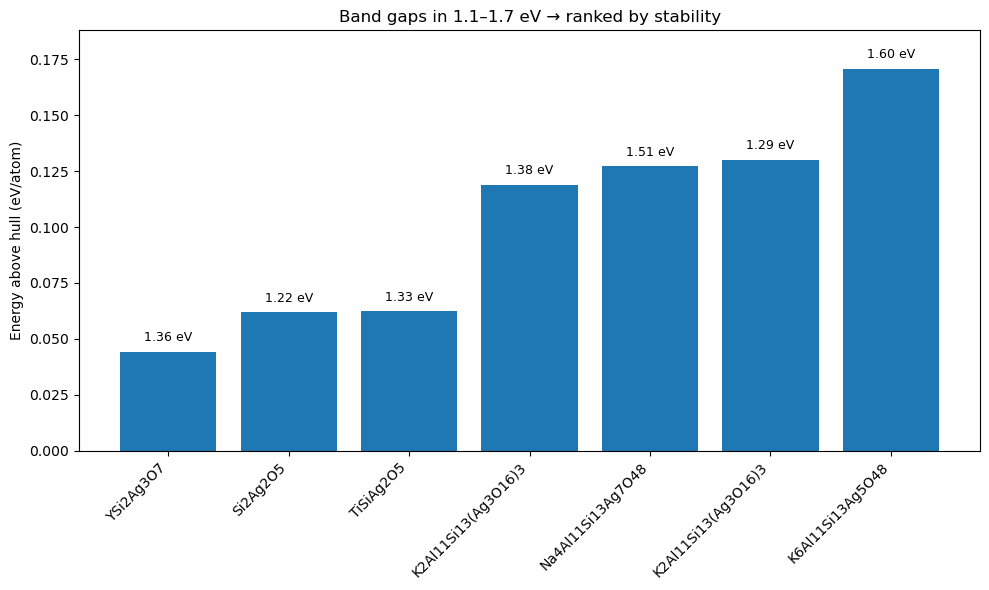

In [ ]:
import matplotlib.pyplot as plt
from mp_api.client import MPRester

#parameters
API_KEY = "YOUR API KEY"
BG_MIN  = 1.1                   # eV
BG_MAX  = 1.7                   # eV
TOPN    = 20                    # how many to display

# (Optional) filter by elements
el_input = input("Enter elements to include (e.g. 'Si,O'), or hit Enter for all: ").strip()
elements = [e.strip().capitalize() for e in el_input.split(",")] if el_input else []

#Query using the summary search
with MPRester(API_KEY) as mpr:
    # Build kwargs (keyword arguments) for the summary switch
    search_kwargs = {
        "band_gap": (BG_MIN, BG_MAX),
        "fields": ["material_id", "formula_pretty", "band_gap", "energy_above_hull"]
    }
    if elements:
        search_kwargs["elements"] = elements

    docs = mpr.materials.summary.search(**search_kwargs)
    results = []
    for doc in docs:
        results.append({
            "material_id": doc.material_id,
            "formula_pretty": doc.formula_pretty,
            "band_gap": doc.band_gap,
            "energy_above_hull": doc.energy_above_hull
        })

#Rank by stability
best = sorted(results, key=lambda d: d["energy_above_hull"])[:TOPN]

#output
print(f"\nTop {len(best)} materials (band gap {BG_MIN}-{BG_MAX} eV), ranked by E_above_hull:")
for idx, m in enumerate(best, start=1):
    print(f"{idx}. {m['formula_pretty']} ({m['material_id']}): "
          f"gap {m['band_gap']:.2f} eV, E_above_hull {m['energy_above_hull']:.3f} eV/atom")

# Visualization of bar chart and annotated with band gap
formulas = [m["formula_pretty"] for m in best]
stabs    = [m["energy_above_hull"]     for m in best]
gaps     = [m["band_gap"]         for m in best]

# Drops entries with a value of zero on the y-axis
keep = [i for i, e in enumerate(stabs) if e > 0]
formulas = [formulas[i] for i in keep]
stabs    = [stabs[i]    for i in keep]
gaps     = [gaps[i]     for i in keep]

plt.figure(figsize=(10,6))
bars = plt.bar(range(len(formulas)), stabs)
plt.xticks(range(len(formulas)), formulas, rotation=45, ha="right")
plt.ylabel("Energy above hull (eV/atom)")
plt.title(f"Band gaps in {BG_MIN:.1f}–{BG_MAX:.1f} eV → ranked by stability")
plt.ylim(0, max(stabs)*1.1)

# annotate each bar with its band gap
for i, (stab, gap) in enumerate(zip(stabs, gaps)):
    plt.text(i, stab + max(stabs)*0.02, f"{gap:.2f} eV",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
